# Wine RAG Preparation

In [1]:
#Inspiration and help from https://cognitiveclass.ai/courses/find-your-best-bottle-of-wine-with-nlp

# Dataset Preparation

In [4]:
!pip install kagglehub faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 68.1 MB/s eta 0:00:00


In [5]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Now safe to import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
import faiss
import kagglehub
from kagglehub import KaggleDatasetAdapter

In [6]:
# Set the path to the file you'd like to load
file_path = "winemag-data-130k-v2.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "zynicide/wine-reviews",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

100%|██████████| 16.4M/16.4M [00:00<00:00, 89.3MB/s]

Extracting zip of winemag-data-130k-v2.csv...


First 5 records:    Unnamed: 0   country                                        description  \
0           0     Italy  Aromas include tropical fruit, broom, brimston...   
1           1  Portugal  This is ripe and fruity, a wine that is smooth...   
2           2        US  Tart and snappy, the flavors of lime flesh and...   
3           3        US  Pineapple rind, lemon pith and orange blossom ...   
4           4        US  Much like the regular bottling from 2012, this...   

                          designation  points  price           province  \
0                        Vulkà Bianco      87    NaN  Sicily & Sardinia   
1                            Avidagos      87   15.0              Douro   
2                                 NaN      87   14.0             Oregon   
3                Reserve Late Harvest      87   13.0           Michigan   
4  Vintner's Reserve Wild Child Block      87   65.0             Oregon   

              region_1           region_2         taster_name  

In [7]:
print(df.shape)
df = df.drop_duplicates('description')
print(df.shape)

(129971, 14)
(119955, 14)


In [8]:
df.isnull().sum()

,0
Unnamed: 0,0
country,59
description,0
designation,34532
points,0
price,8388
province,59
region_1,19558
region_2,73195
taster_name,24912


In [9]:
df = df.dropna(subset=['price'])
df.shape

(111567, 14)

In [10]:
# set index to country
country = df.set_index("country")

# extract only Italy wines
Italy = country.loc[["Italy"]]
Italy.head()

,Unnamed: 0,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
country,,,,,,,,,,,,,
Italy,6,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
Italy,22,Delicate aromas recall white flower and citrus...,Ficiligno,87,19.0,Sicily & Sardinia,Sicilia,NaN,Kerin O’Keefe,@kerinokeefe,Baglio di Pianetto 2007 Ficiligno White (Sicilia),White Blend,Baglio di Pianetto
Italy,24,"Aromas of prune, blackcurrant, toast and oak c...",Aynat,87,35.0,Sicily & Sardinia,Sicilia,NaN,Kerin O’Keefe,@kerinokeefe,Canicattì 2009 Aynat Nero d'Avola (Sicilia),Nero d'Avola,Canicattì
Italy,26,Pretty aromas of yellow flower and stone fruit...,Dalila,87,13.0,Sicily & Sardinia,Terre Siciliane,NaN,Kerin O’Keefe,@kerinokeefe,Stemmari 2013 Dalila White (Terre Siciliane),White Blend,Stemmari
Italy,27,"Aromas recall ripe dark berry, toast and a whi...",NaN,87,10.0,Sicily & Sardinia,Terre Siciliane,NaN,Kerin O’Keefe,@kerinokeefe,Stemmari 2013 Nero d'Avola (Terre Siciliane),Nero d'Avola,Stemmari


In [11]:
# US and Spain wines
us_spain = df[(df["country"] == "US") | (df["country"] == "Spain")]
us_spain.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
10,10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature


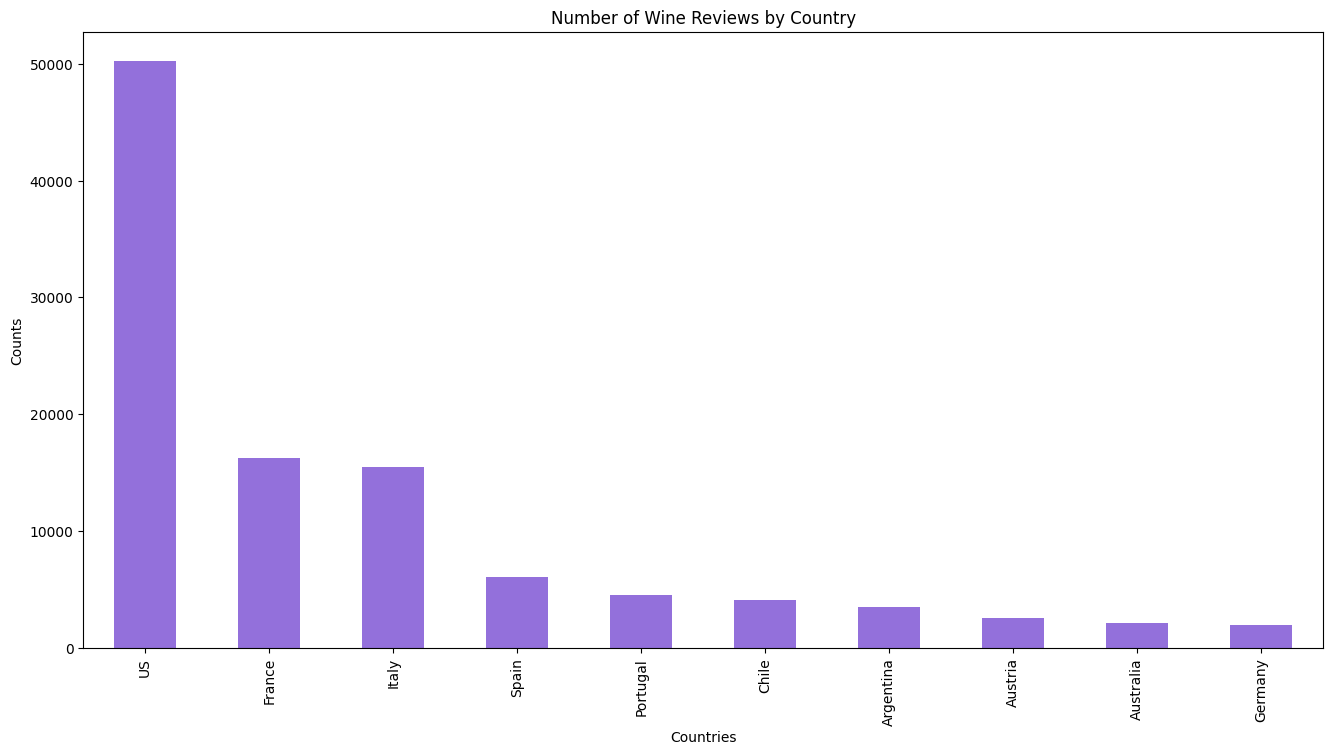

In [12]:
# Plot countries with the most reviews
df.country.value_counts().iloc[:10].plot(kind = 'bar', figsize = (16, 8), color = "#9370DB")
plt.title('Number of Wine Reviews by Country')
plt.ylabel('Counts')
plt.xlabel('Countries')
plt.show()

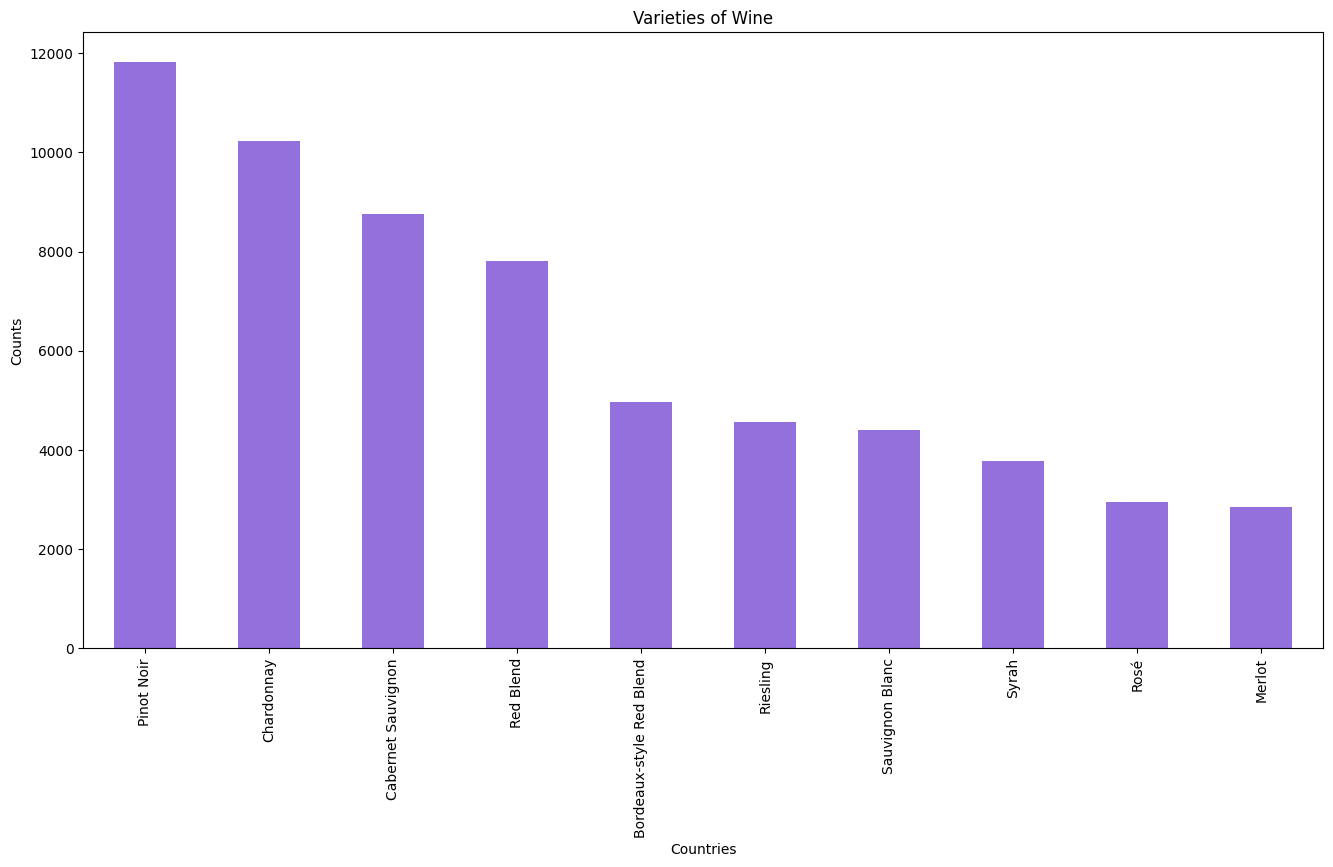

In [13]:
# Top 10 varieties
df.variety.value_counts().iloc[:10].plot(kind = 'bar', figsize = (16, 8),  color = "#9370DB")
plt.title('Varieties of Wine')
plt.ylabel('Counts')
plt.xlabel('Countries')
plt.show()

[Text(0.5, 1.0, 'The Most Expensive Varieties')]

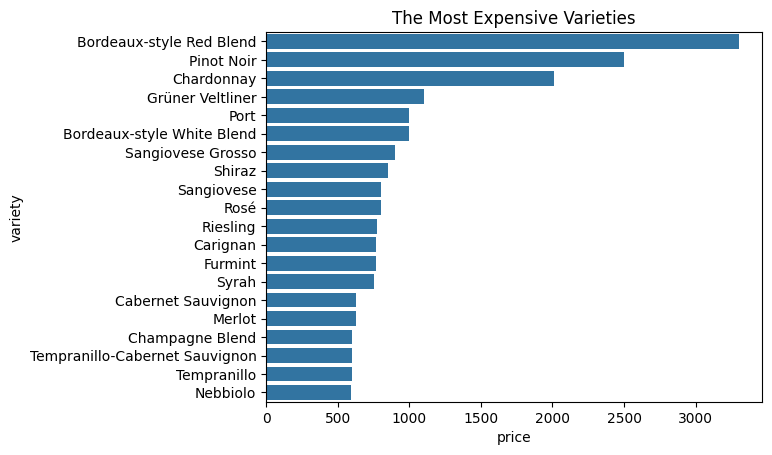

In [14]:
# Find and plot the most expensive varieties
exp_wines = df.groupby(['variety'])['price'].max().sort_values(ascending = False).to_frame()[:20]
# exp_wines.plot(kind = 'bar', figsize = (16, 8), color = "#9370DB")
# plt.title('Most Expensive Wine Varieties')
# plt.ylabel('Price')
# plt.xlabel('Variety')
# plt.show()
sns.barplot(x = exp_wines['price'], y = exp_wines.index).set(title='The Most Expensive Varieties')

# RAG

In [16]:
# Embedding the descriptions
model = SentenceTransformer('all-MiniLM-L6-v2')
wine_embeddings = model.encode(df['description'].tolist(), show_progress_bar=True)
wine_embeddings = np.array(wine_embeddings).astype('float32') # For FAISS

# Save the embeddings
np.save('/content/wine_embeddings.npy', wine_embeddings)

# Save the wine metadata
df.to_csv('/content/wine_metadata.csv', index=False)


Batches:   0%|          | 0/3487 [00:00<?, ?it/s]

In [17]:
# Building the FAISS Index
index = faiss.IndexFlatL2(wine_embeddings.shape[1])
index.add(wine_embeddings)

print(f"FAISS index Size: {index.ntotal}")

FAISS index Size: 111567


In [19]:
# Creating the search function
def search_wines(query, top_k=5):
    query_vec = model.encode([query]).astype('float32')
    distances, ids = index.search(query_vec, top_k)

    results = df.iloc[ids[0]][['title', 'description', 'country', 'variety', 'points', 'price']]
    return results

In [23]:
# This is a function for printing the wine results in an understandable format
def pretty_print_wines(results):
    for idx, row in results.iterrows():
        title = row['title']
        description = row['description']
        country = row['country']
        variety = row['variety']
        points = row['points']
        price = row['price']

        output = f"""
🍷 {title} ({country}) - {variety}
- Description: {description}
- Points: {points} | Price: ${price}
        """
        print(output)

In [22]:
# Testing...
query = "I'm having seafood, what wine should I drink?"
results = search_wines(query)

pretty_print_wines(results)


🍷 Frankland Estate 2002 Cooladerra Vineyard Riesling (Western Australia) (Australia) - Riesling
- Description: The pairing possibilities with this wine seem endless: seafood of all kinds, chicken, pasta salad, maybe pork, but it'd also make perfect sense to drink it as an aperitif. Clean and dry in the mouth, mineral and chalk are at the fore, with lime pith, soy and grass underneath. Finishes medium-long, with more of the same.
- Points: 89 | Price: $18.0
        

🍷 Monte Volpe 2012 Sesso White (Mendocino County) (US) - White Blend
- Description: A light-drinking, high-acid white that's crisp with layers of floral-laced citrus and herb. An enjoyable sipping wine or one that'll pair easily with fresh seafood.
- Points: 86 | Price: $18.0
        

🍷 Feudi di San Gregorio 2011 White (Lacryma Christi del Vesuvio) (Italy) - White Blend
- Description: Bright and citrus-driven, this no-fuss wine would pair with grilled shrimp or freshwater fish. The wine is zesty and fresh overall.
- Point